In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sp500_stocks.csv
/kaggle/input/sp500_companies.csv
/kaggle/input/sp500_index.csv


**Data Loading**

In [5]:
data = pd.data = pd.read_csv('/kaggle/input/sp500_index.csv',index_col='Date')

In [6]:
cl = pd.Series(data=data['S&P500'][-1250:])
#patch the last entry which is not yet available when generating this run
if cl.index[-1] == '2023-12-19':
    lc = pd.Series([4698.35],index=['2023-12-20'])
    cl = pd.concat([cl, lc])
    #lc = pd.Series([3983.17],index=['2023-01-12'])
    #cl = cl.append(lc)
cl.tail()

Date
2024-04-25    5048.42
2024-04-26    5099.96
2024-04-29    5116.17
2024-04-30    5035.69
2024-05-01    5018.39
Name: S&P500, dtype: float64

**Data Scaling**

In [8]:
from sklearn.preprocessing import MinMaxScaler


In [9]:
cv = cl.values

scl = MinMaxScaler()
#Scale the data
#cl = cl.reshape(cl.shape[0],1)
cv = cv.reshape(cv.shape[0],1)
cv = scl.fit_transform(cv)
display(cv[0:10])

array([[0.20337095],
       [0.21177679],
       [0.20621157],
       [0.19981438],
       [0.20781253],
       [0.20513101],
       [0.19385141],
       [0.19511759],
       [0.18727191],
       [0.18085152]])

In [10]:
def processData(data,lb,gap):
    X,Y = [],[]
    for i in range(len(data)-lb-gap):
        X.append(data[i:(i+lb),0])
        Y.append(data[(i+lb+gap),0])
    return np.array(X),np.array(Y)
X,y = processData(cv,14,1)
X_train,X_test = X[:int(X.shape[0]*0.80)],X[int(X.shape[0]*0.80):]
y_train,y_test = y[:int(y.shape[0]*0.80)],y[int(y.shape[0]*0.80):]
print(X_train.shape[0])
print(X_test.shape[0])
print(y_train.shape[0])
print(y_test.shape[0])

988
247
988
247


**LSTM**

In [8]:
from keras.models import Sequential
from keras.layers import LSTM, Flatten, Dense

model = Sequential()
model.add(LSTM(5, activation='relu', input_shape=(14, 1)))
model.add(Flatten())
model.add(Dense(40, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='mse')
print(model.summary())


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5)              │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 40)             │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421 (1.64 KB)

 Trainable params: 421 (1.64 KB)

 Non-trainable params: 0 (0.00 B)

None


In [9]:
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
print(X_train.shape)
print(X_train[0])
print(X_train[1])

(988, 14, 1)
[[0.21280432]
 [0.20992062]
 [0.21346061]
 [0.19041416]
 [0.19788528]
 [0.20337095]
 [0.21177679]
 [0.20621157]
 [0.19981438]
 [0.20781253]
 [0.20513101]
 [0.19385141]
 [0.19511759]
 [0.18727191]]
[[0.20992062]
 [0.21346061]
 [0.19041416]
 [0.19788528]
 [0.20337095]
 [0.21177679]
 [0.20621157]
 [0.19981438]
 [0.20781253]
 [0.20513101]
 [0.19385141]
 [0.19511759]
 [0.18727191]
 [0.18085152]]


In [11]:
history = model.fit(X_train,y_train,epochs=200,validation_data=(X_test,y_test),shuffle=False,verbose=2)    

Epoch 1/200
31/31 - 3s - 88ms/step - loss: 0.0632 - val_loss: 0.1595
Epoch 2/200
31/31 - 0s - 9ms/step - loss: 0.0345 - val_loss: 0.0881
Epoch 3/200
31/31 - 0s - 9ms/step - loss: 0.0319 - val_loss: 0.0577
Epoch 4/200
31/31 - 0s - 8ms/step - loss: 0.0313 - val_loss: 0.0353
Epoch 5/200
31/31 - 0s - 10ms/step - loss: 0.0271 - val_loss: 0.0102
Epoch 6/200
31/31 - 0s - 10ms/step - loss: 0.0206 - val_loss: 0.0033
Epoch 7/200
31/31 - 0s - 10ms/step - loss: 0.0129 - val_loss: 0.0033
Epoch 8/200
31/31 - 0s - 9ms/step - loss: 0.0076 - val_loss: 0.0035
Epoch 9/200
31/31 - 0s - 9ms/step - loss: 0.0053 - val_loss: 0.0044
Epoch 10/200
31/31 - 0s - 9ms/step - loss: 0.0043 - val_loss: 0.0059
Epoch 11/200
31/31 - 0s - 8ms/step - loss: 0.0037 - val_loss: 0.0079
Epoch 12/200
31/31 - 0s - 10ms/step - loss: 0.0033 - val_loss: 0.0100
Epoch 13/200
31/31 - 0s - 10ms/step - loss: 0.0032 - val_loss: 0.0119
Epoch 14/200
31/31 - 0s - 10ms/step - loss: 0.0034 - val_loss: 0.0130
Epoch 15/200
31/31 - 0s - 10ms/step 

In [13]:
hist = history.history

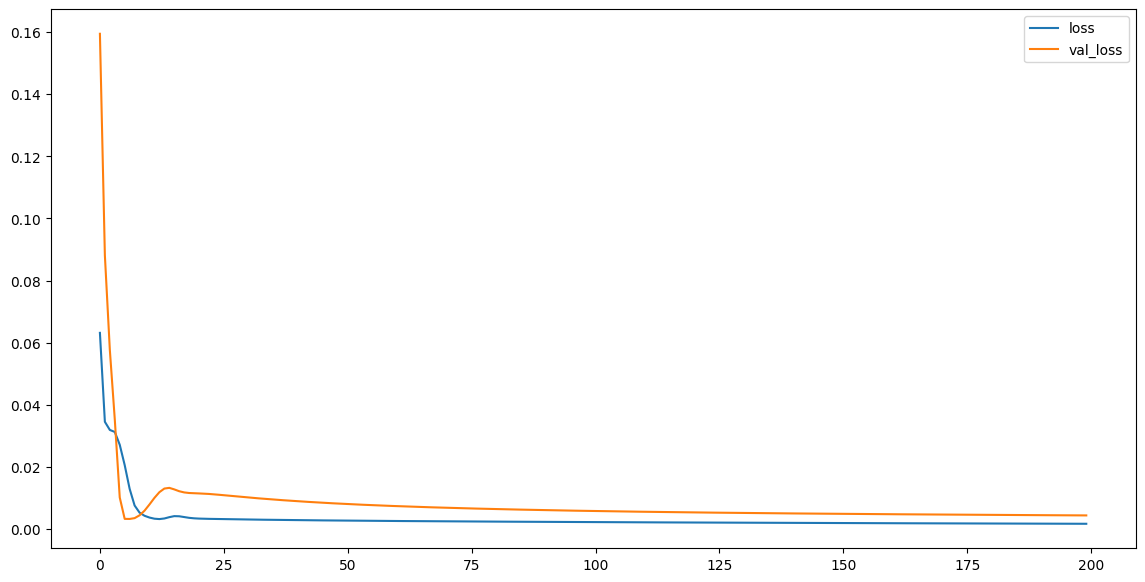

In [14]:
plt.figure(figsize=(14,7))
plt.plot(hist['loss'],label='loss')
plt.plot(hist['val_loss'],label='val_loss')
plt.legend()
plt.show()

In [15]:
Xt = model.predict(X_test)
yactual = pd.Series(scl.inverse_transform(y_test.reshape(-1,1)).reshape(-1))
ypred = pd.Series((scl.inverse_transform(Xt)).reshape(-1))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [16]:
yema = yactual.ewm(span=3).mean()
signal = pd.Series(index = yactual.index, data = np.zeros(yactual.size))
pdiff = ypred.diff(3)
adiff = yema.diff(3)
print(adiff[-5:])
print(pdiff[-5:])
for i in yactual.index:
    if (pdiff[i] > 0 and adiff[i] > 0) or (pdiff[i] < 0 and adiff[i] < 0):
        signal[i] = 4700.0
    else:
        signal[i] = 4600.0
del pdiff
del adiff

242   -78.212463
243   -81.196231
244   -46.403116
245     6.513442
246    55.456721
dtype: float64
242   -21.550781
243   -23.887695
244   -22.681641
245   -25.111816
246   -19.810547
dtype: float32


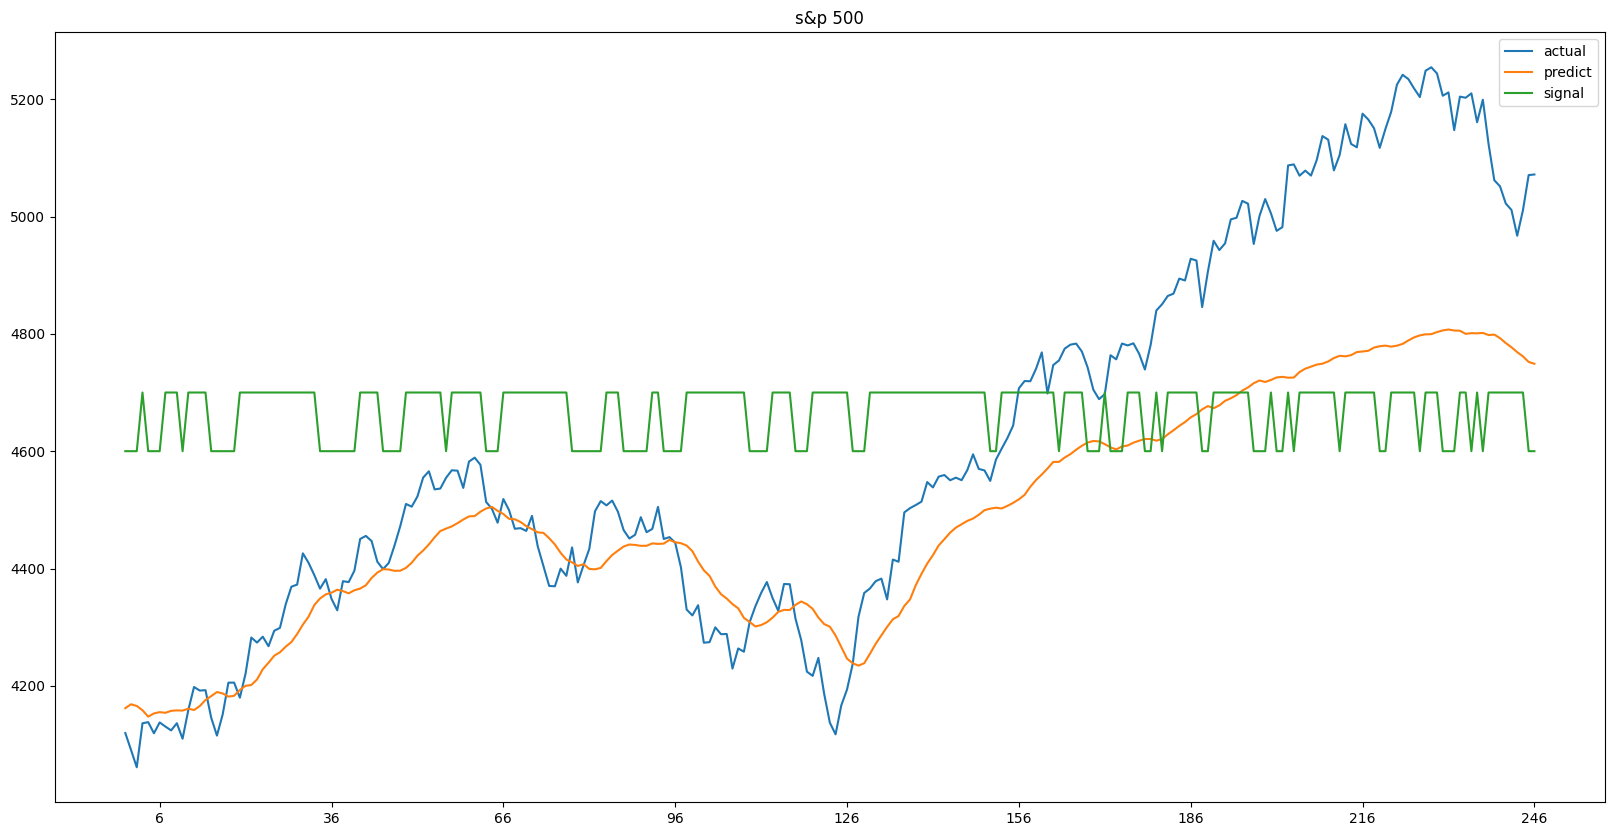

In [17]:
plt.figure(figsize=(20,10))
ax = plt.axes()
ax.plot(yactual, label='actual')
ax.plot(ypred, label='predict')
#plt.plot(yema)
ax.plot(signal, label='signal')
ax.set_xticks(yactual.index[6::30])
#plt.annotate('late pred',(137,4200))
#plt.axvline(x=135.0, color='r', linestyle='-')
#plt.annotate('late pred',(233,4300))
#plt.axvline(x=333, color='r', linestyle='-')
plt.title('s&p 500')
plt.legend()
plt.show()

In [20]:
# Reshape X_train and X_test to be 2D arrays
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)


**Linear regression**

In [23]:
from sklearn.linear_model import LinearRegression

# Feature engineering (using lagged values of the time series as features)
# Split the data into training and testing sets
# Train the linear regression model
model_lr = LinearRegression()
model_lr.fit(X_train_reshaped, y_train)






LinearRegression()

In [24]:
# Make predictions
predictions_lr = model_lr.predict(X_test_reshaped)


In [25]:
# Evaluate the model (calculate MSE or other appropriate metrics)
# Visualize results
from sklearn.metrics import mean_squared_error

# Evaluate the model (calculate MSE or other appropriate metrics)
mse_lr = mean_squared_error(y_test, predictions_lr)
print('Mean Squared Error (Linear Regression):', mse_lr)

Mean Squared Error (Linear Regression): 0.0002728107235353846


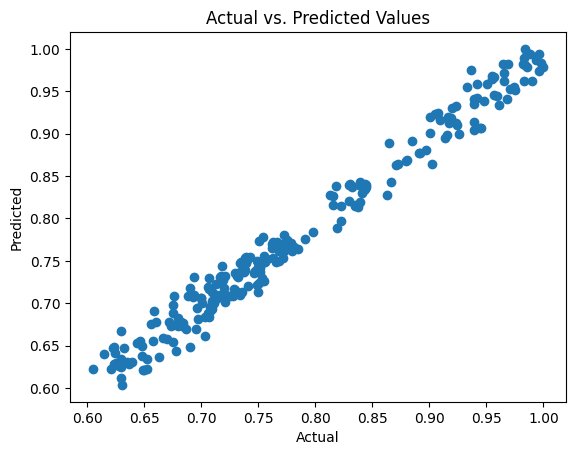

In [27]:
import matplotlib.pyplot as plt

# Scatter plot of actual vs. predicted values
plt.scatter(y_test, predictions_lr)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values')
plt.show()


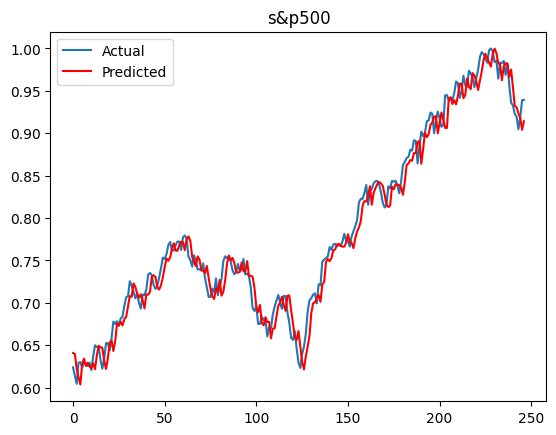

In [30]:
import matplotlib.pyplot as plt

# Plot actual values (y_test) against predicted values (predictions_lr)
plt.plot( y_test, label='Actual')
plt.plot( predictions_lr, color='red', label='Predicted')

# Add legend
plt.legend()

plt.title('s&p500')

# Show plot
plt.show()


**Arima**

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA


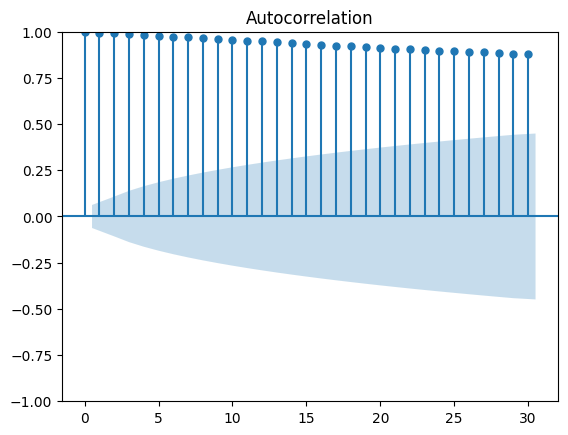

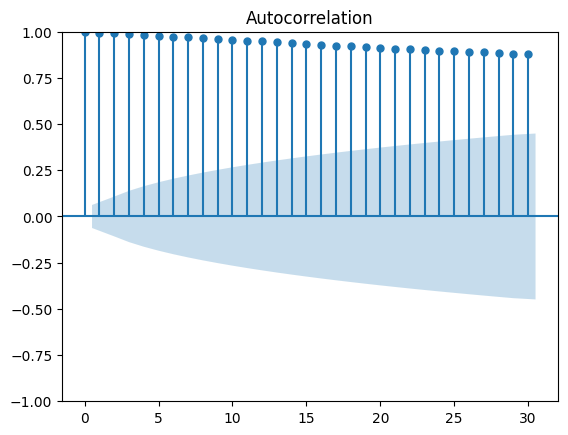

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot autocorrelation and partial autocorrelation plots
plot_acf(X_train[:, 0])
plt.show()


plot_acf(X_train[:, 0])
plt.show()


In [23]:
p=1 
q=0
d=1

endog_variable = X_train[:, 0]  # Selecting the first column
model = ARIMA(endog_variable, order=(p, d, q))
fitted_model = model.fit()



                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  988
Model:                 ARIMA(1, 1, 0)   Log Likelihood                2666.906
Date:                Thu, 02 May 2024   AIC                          -5329.812
Time:                        08:13:55   BIC                          -5320.022
Sample:                             0   HQIC                         -5326.089
                                - 988                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1255      0.019     -6.702      0.000      -0.162      -0.089
sigma2         0.0003   7.05e-06     37.318      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.05   Jarque-

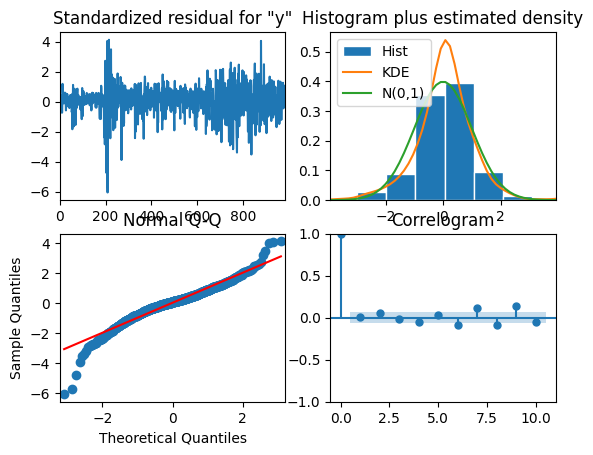

In [24]:
print(fitted_model.summary())
fitted_model.plot_diagnostics()
plt.show()


In [25]:
forecast = fitted_model.forecast(steps=len(X_test))


In [35]:
print("Length of X_test:", len(X_test))
print("Shape of forecast:", forecast.shape)
print("Shape of X_test:",X_test.shape)


Length of X_test: 247
Shape of forecast: (247,)
Shape of X_test: (247, 14)


In [37]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Aggregate multiple outputs in X_test
X_test_aggregated = np.mean(X_test, axis=1)

# Compute RMSE
rmse = mean_squared_error(X_test_aggregated, forecast, squared=False)
print("RMSE:", rmse)


RMSE: 0.18188317226102133


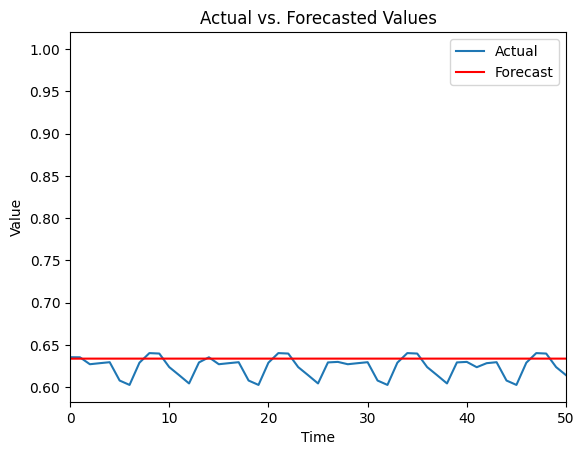

In [40]:
import matplotlib.pyplot as plt

# Plot actual vs. forecasted values
plt.plot(X_test.ravel(), label='Actual')
plt.plot(forecast, label='Forecast', color='red')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs. Forecasted Values')
plt.xlim(0, 50)  # Set x-axis limits
plt.legend()
plt.show()


**SARIMAX**

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.52081D+00    |proj g|=  1.75880D+01


 This problem is unconstrained.



At iterate    5    f= -2.57866D+00    |proj g|=  3.57391D-01

At iterate   10    f= -2.58250D+00    |proj g|=  5.83233D+00

At iterate   15    f= -2.59893D+00    |proj g|=  5.44050D+00

At iterate   20    f= -2.62021D+00    |proj g|=  1.36308D+00

At iterate   25    f= -2.62179D+00    |proj g|=  1.10697D+00

At iterate   30    f= -2.63872D+00    |proj g|=  7.21128D-01

At iterate   35    f= -2.64176D+00    |proj g|=  2.18124D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     62      1     0     0   4.479D-03  -2.642D+00
  F =  -2.6417780398524493     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RMSE: 0.12607746624239013


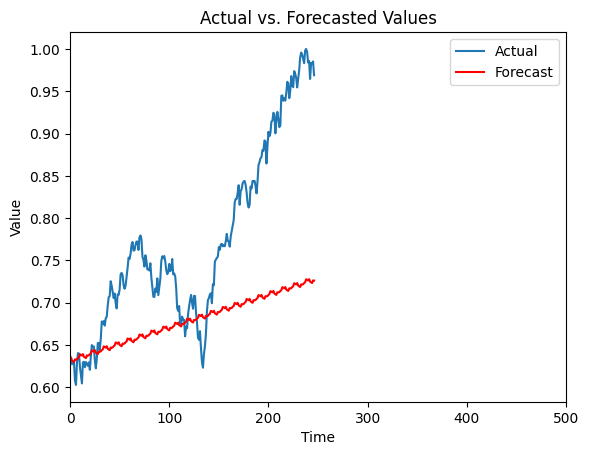

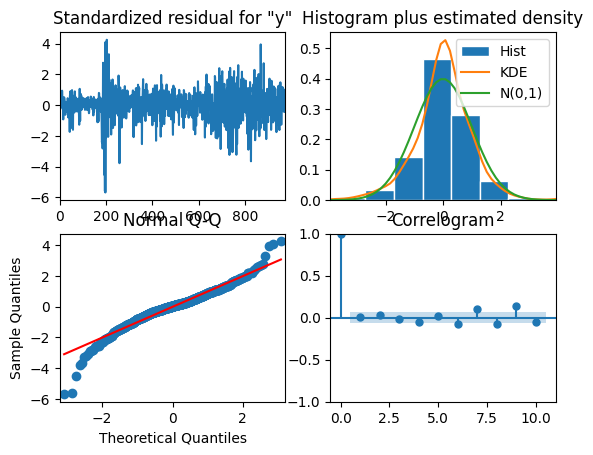

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Assuming you have already loaded and preprocessed your data, and split it into X_train and X_test

# Fit SARIMA model
endog_variable = X_train[:, 0]  # Selecting the first column, adjust index as needed

# Fit SARIMA model
order = (1, 1, 1)  # Example order (p, d, q)
seasonal_order = (1, 1, 1, 12)  # Example seasonal order (P, D, Q, S)
model = SARIMAX(endog_variable, order=order, seasonal_order=seasonal_order)
fitted_model = model.fit()

# Forecast
forecast = fitted_model.forecast(steps=len(X_test))

# Compute RMSE
rmse = mean_squared_error(X_test[:, 0], forecast, squared=False)  # Assuming you want to compare the forecast with the first column of X_test
print("RMSE:", rmse)

# Plot actual vs. forecasted values
plt.plot(X_test[:, 0], label='Actual')  # Assuming you want to plot the first column of X_test
plt.plot(forecast, label='Forecast', color='red')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs. Forecasted Values')
plt.xlim(0, 500)  # Set x-axis limits
plt.legend()
plt.show()

# Additional diagnostics
fitted_model.plot_diagnostics()
plt.show()
